# Setup

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from imutils.paths import list_images
import cv2

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     Activation, MaxPool2D, UpSampling2D,
                                     Concatenate, Dropout)
from tensorflow.keras.models import Model

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.6.0'

In [4]:
!nvidia-smi

Tue Aug 24 15:42:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Config

In [5]:
# set the random seed for random number generator to produce 
# similar results every time
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
DRIVE_PATH = r'/content/drive/MyDrive'

In [ ]:
!unrar x /content/drive/MyDrive/dataset.rar

In [7]:
# Setup training, validation and testing paths
# same with image collection notebook
TRAIN_PATH = os.path.join("training")
VAL_PATH = os.path.join("validation")
TEST_PATH = os.path.join("testing")

In [8]:
os.path.exists(TRAIN_PATH)

True

In [9]:
# the image size that we want to resize into for training
IMG_HEIGHT = 224
IMG_WIDTH = 224
# 3 channels for our RGB images
IMG_CHANNELS = 3

# we have 3 classes in this example: main, background, border
N_CLASSES = 3

## Training config

In [10]:
OUTPUTS_PATH = os.path.join(DRIVE_PATH, "outputs")
os.makedirs(OUTPUTS_PATH, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUTS_PATH, "pets_segmentation.h5")

In [12]:
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 30

# Preprocess the dataset

In [28]:
def get_dataPaths(directory):
    # get the image and mask paths and MUST SORT them 
    # to align the image to the corresponding mask
    imagePaths = os.path.join(directory, "images")
    imagePaths = sorted(list(list_images(imagePaths)))
    maskPaths = os.path.join(directory, "annotations")
    maskPaths = sorted(list(list_images(maskPaths)))
    return np.array(imagePaths), np.array(maskPaths)

In [29]:
def read_image(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.astype(np.float32) / 255.
    return img

def read_mask(maskPath):
    mask = cv2.imread(maskPath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    # minus 1 to reduce the minimum pixel value from 1 to 0
    # for the model training to work properly
    mask = mask - 1
    mask = mask.astype(np.int32)
    return mask

In [30]:
def preprocess_data(imagePath, maskPath):
    def py_func(imagePath, maskPath):
        imagePath = imagePath.decode()
        maskPath = maskPath.decode()
        
        img = read_image(imagePath)
        mask = read_mask(maskPath)
        return img, mask
    
    # wrap the function and use it as a TF operation
    # to optimize for performance
    img, mask = tf.numpy_function(
        py_func,
        [imagePath, maskPath],
        [tf.float32, tf.int32]
    )
    
    # this is a very important step to one-hot encode the mask
    # based on the number of classes, and keep in mind that
    # this N_CLASSES will be the same as the number of filters of the 
    # final output Conv2D layer that we will build later
    mask = tf.one_hot(mask, depth=N_CLASSES, dtype=tf.int32)
    
    # set the shape to let TensorFlow knows about the shape
    # just like `assert`
    # NOTE: this step is required to show metrics during training
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])
    
    return img, mask

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_imagePaths, train_maskPaths = get_dataPaths(TRAIN_PATH)
train_ds = tf.data.Dataset.from_tensor_slices((train_imagePaths, train_maskPaths))
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

val_imagePaths, val_maskPaths = get_dataPaths(VAL_PATH)
val_ds = tf.data.Dataset.from_tensor_slices((val_imagePaths, val_maskPaths))
val_ds = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

test_imagePaths, test_maskPaths = get_dataPaths(TEST_PATH)
test_ds = tf.data.Dataset.from_tensor_slices((test_imagePaths, test_maskPaths))
test_ds = test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

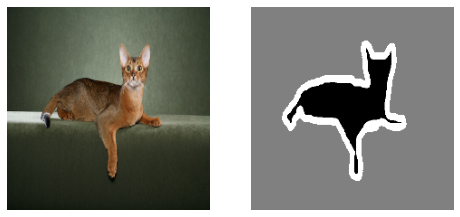

Unique pixel values: [0 1 2]


In [32]:
img = read_image(train_imagePaths[0])
plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')

mask = read_mask(train_maskPaths[0])
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

print("Unique pixel values:", np.unique(mask))

In [33]:
for img, mask in train_ds.take(1):
    # the mask is one-hot encoded for each class, 3 in this case
    print(img.shape)
    print(mask.shape)

(224, 224, 3)
(224, 224, 3)


In [34]:
# converted to one-hot encoded labels across the "depth" axis,
# where this axis corresponds to the axis of the feature maps of 
# CNN layer
np.unique(mask.numpy())

array([0, 1], dtype=int32)

# Optimize the tf.data.Dataset for performance

As explained in my previous notebooks for [image classification](https://github.com/ansonnn07/image-classification/blob/main/2.%20Training%20-%20Sign%20Language.ipynb).

In [35]:
train_ds = (train_ds
            .shuffle(len(train_imagePaths))
            .cache()
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE)
)

val_ds = (val_ds
          # no shuffle
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE)
)

test_ds = (test_ds
           # no shuffle
           .cache()
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE)
)

# Build Model

The model that we are building here is none other than the [U-net architecture](https://arxiv.org/abs/1505.04597) which was pioneered for image segmentation. The name was defined with "U" because of how it looks like a "U" shape in the figure below.

The model begins with an encoder path (at the left of the figure below), going down with deeper and deeper feature maps until it reaches a **bridge** at the center; and finally a decoder path at the right that expands the small spatial dimensions (also large depths) back to the original image shape at the end. Here is a brief summary:
- The input image size and the output mask size are identical to allow classification of each pixel in the original image.
- The encoder essentially learns about the features required to distinguish each class, while the decoder will try to classify each pixel into different classes.
- The decoder takes features from the encoder path and concatenate them together to be able to learn more efficiently. You can see them in the figure from the long arrows spanning across  from left to right.

![modified U-net architecture](https://github.com/ansonnn07/image-segmentation/blob/main/images/modified_u-net_architecture.png?raw=1)

Image source: from YouTube [video](https://youtu.be/68HR_eyzk00?list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) by DigitalSreeni

In [36]:
def conv_block(inputs, filters, batch_norm=True, dropout=0, pool=True):
    # These Conv layers are using strides of 1 with "same" padding
    # to retain the  spatial dimension while increasing the depths
    # according to the number of filters (aka feature maps).
    # The kernel size is 3x3 (specified as the 3 here)
    x = Conv2D(filters, 3, padding="same", kernel_initializer='he_normal')(inputs)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout != 0:
        x = Dropout(dropout)(x)

    x = Conv2D(filters, 3, padding="same", kernel_initializer='he_normal')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(input_shape, num_classes, batch_norm=True):
    """
    Input_shape must follow your resized image size.
    You may also enable or disable BatchNormalization with the `batch_norm`.
    You may also change the number of filters but the opposite layer in the
    decoder path must follow exactly the same number of filters.
    Dropout fractions also can be adjusted as you like. But the max pooling
    layers should be maintained for the best results.
    """
    
    # clear session to regain some unused memory
    tf.keras.backend.clear_session()
    
    inputs = Input(input_shape)

    ## ENCODER
    x1, p1 = conv_block(inputs, 16, batch_norm, dropout=0.1, pool=True)
    x2, p2 = conv_block(p1, 32, batch_norm, dropout=0.1, pool=True)
    x3, p3 = conv_block(p2, 64, batch_norm, dropout=0.2, pool=True)
    x4, p4 = conv_block(p3, 128, batch_norm, dropout=0.2, pool=True)

    ## BRIDGE/CENTER
    b1 = conv_block(p4, 256, batch_norm, dropout=0.3, pool=False)

    ## DECODER
    # upsample and concatenate with the encoder layers at the same time
    # until we reaches the same spatial dimensions as the original input shape
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 128, batch_norm, dropout=0.2, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 64, batch_norm, dropout=0.2, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, batch_norm, dropout=0.1, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, batch_norm, dropout=0.1, pool=False)

    ## Final output layer
    # the num_classes must follow the number of depths (N_CLASSES in this case) 
    # that we defined for the one-hot encoded masks explained during the preprocessing
    # This is to make sure that the output shape aligns with our label/mask shape
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs=inputs, outputs=output)

In [37]:
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), N_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Then, Plot the model architecture summary if you want.

NOTE: You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/), for plot_model/model_to_dot to work.

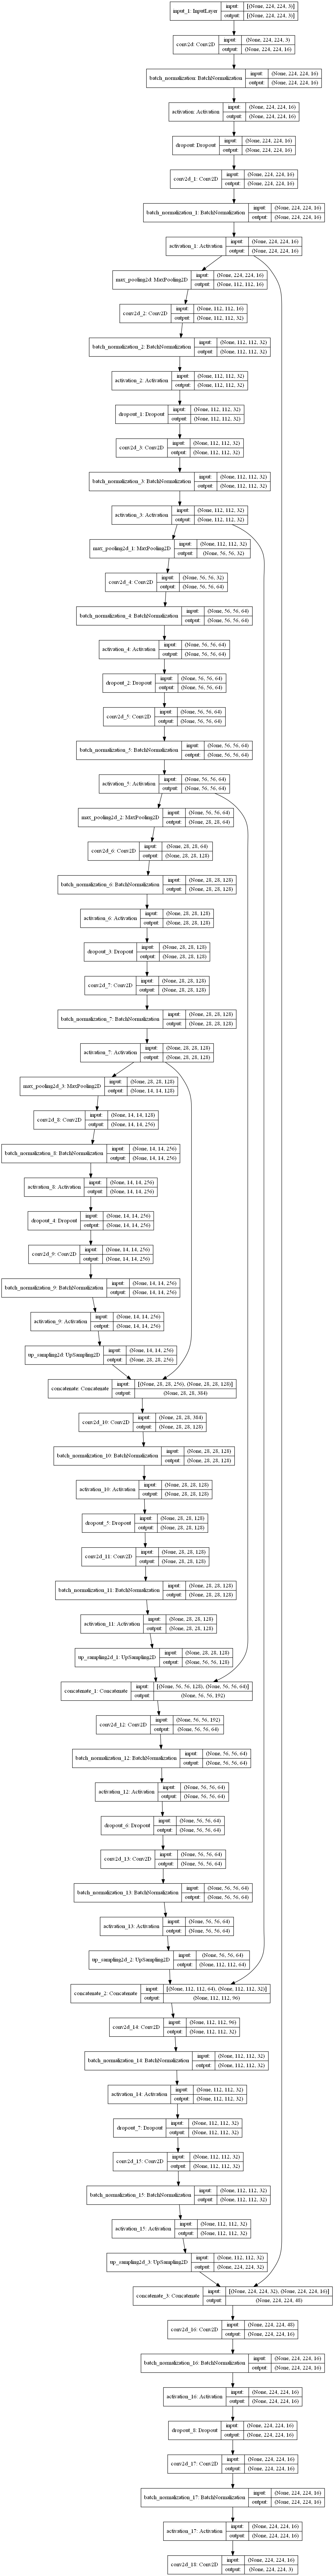

In [ ]:
model_graph_path = os.path.join(OUTPUTS_PATH, "my_model.png")
tf.keras.utils.plot_model(model, to_file=model_graph_path, show_shapes=True)

# Training

In [38]:
## defining some extra callbacks to use, this is not necessary for training
#  they are just used for quality of life

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# this callback saves the checkpoint weights with the best `val_loss` every epoch
checkpoint_filepath = os.path.join(OUTPUTS_PATH, 'weights.h5')
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

# this callback will stop the training when the `val_loss` has not changed for
#   3 epochs, as specified by the `patience` parameter
# `restore_best_weights` is used to restore the model to the best checkpoint 
#   after training
early_stopping = EarlyStopping(patience=3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

Intersection over Union (IoU) is a very good metric to use for segmentation, although it is also used for object detection to measure how much of our predicted regions intersects with the ground truth regions. You can read more about IoU [here](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/).

But note that metric is only a way to evaluate our model performance, it does not influence the training progress, only the loss function directly influences the training as it is used to update the gradients during training.

There are also some other popular loss functions used for segmentation besides cross entropy, such as dice loss (like F1 score but in terms of IoU) and focal loss. They generally work very well when the dataset is imbalanced. You can read more about them [here](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5).

We are creating a custom metric by subclassing the `MeanIoU` class from `keras` to accommodate our data. Rather than defining this metric as a function, we are using subclassing to retain all the `keras.metrics` functionalities.

In [39]:
# https://stackoverflow.com/questions/60507120/how-to-correctly-use-the-tensorflow-meaniou-metric
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        # we need to take the argmax of both our ground truths
        # and predictions for this metric to work properly
        # because our y_true and y_pred are one-hot encoded
        return super().update_state(
            tf.argmax(y_true, axis=-1),
            tf.argmax(y_pred, axis=-1),
            sample_weight
        )

In [40]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(LR),
              metrics=[MyMeanIOU(num_classes=N_CLASSES)]
              ## accuracy is not really a good metric for segmentation
              # metrics=['accuracy']
)

In [41]:
# train the model
print("[INFO] Training model...")
start_time = time.perf_counter()
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoints, early_stopping],
)
end_time = time.perf_counter()
print(f"[INFO] Total time: {end_time - start_time:.2f} s")

[INFO] Training model...
Epoch 1/30
739/739 [==============================] - 113s 97ms/step - loss: 0.7490 - my_mean_iou: 0.4299 - val_loss: 0.7557 - val_my_mean_iou: 0.3948
Epoch 2/30
739/739 [==============================] - 67s 91ms/step - loss: 0.5511 - my_mean_iou: 0.5414 - val_loss: 0.6029 - val_my_mean_iou: 0.5108
Epoch 3/30
739/739 [==============================] - 68s 91ms/step - loss: 0.4849 - my_mean_iou: 0.5794 - val_loss: 0.5193 - val_my_mean_iou: 0.5598
Epoch 4/30
739/739 [==============================] - 68s 92ms/step - loss: 0.4491 - my_mean_iou: 0.6014 - val_loss: 0.4727 - val_my_mean_iou: 0.5905
Epoch 5/30
739/739 [==============================] - 68s 92ms/step - loss: 0.4242 - my_mean_iou: 0.6175 - val_loss: 0.4734 - val_my_mean_iou: 0.5935
Epoch 6/30
739/739 [==============================] - 68s 92ms/step - loss: 0.4052 - my_mean_iou: 0.6304 - val_loss: 0.4602 - val_my_mean_iou: 0.6014
Epoch 7/30
739/739 [==============================] - 68s 92ms/step - loss

<br>

The validation mean IoU only reaches 64% which is not that good, this requires longer training to achieve better performance. You can choose to train with more epochs to see how it turns out. You can also refer to the tutorial in the official documentation [here](https://www.tensorflow.org/tutorials/images/segmentation) to find out more ways to improve this.

In [42]:
print("[INFO] Saving model ...")
model.save(MODEL_PATH, save_format="h5")

[INFO] Saving model ...


In [43]:
# careful that the custom metric name might be different sometimes
H.history.keys()

dict_keys(['loss', 'my_mean_iou', 'val_loss', 'val_my_mean_iou'])

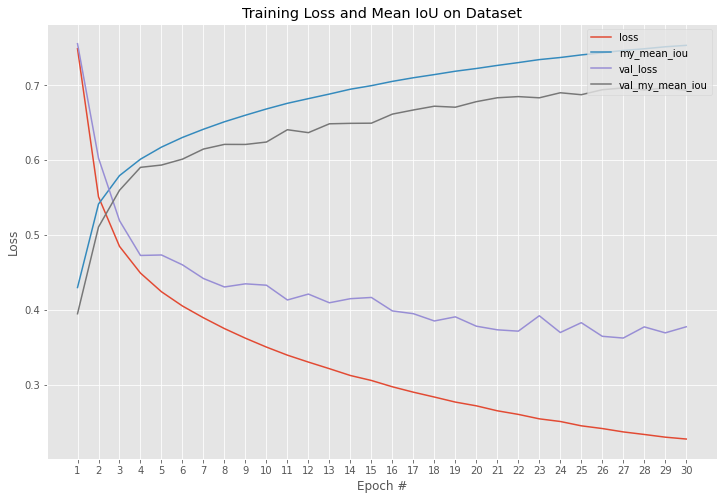

In [48]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.xticks(np.arange(1, N + 1))
for key, values in H.history.items():
    plt.plot(np.arange(1, N + 1), values, label=key)
plt.title("Training Loss and Mean IoU on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

# Evaluation

In [ ]:
# need to specify the custom metric class as a parameter to be able to load it back successfully
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(
            tf.argmax(y_true, axis=-1),
            tf.argmax(y_pred, axis=-1),
            sample_weight
        )
# to show how to load back the trained model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"MyMeanIOU": MyMeanIOU})

In [49]:
# the `evaluate` method will return the loss and any metric(s) we used
loss, meanIoU = model.evaluate(test_ds)
print(loss, meanIoU)

93/93 [==============================] - 6s 68ms/step - loss: 0.3364 - my_mean_iou: 0.7092
0.3364032208919525 0.7092234492301941


In [50]:
# the predictions are in the shape of
# (n_samples, img_height, img_width, n_classes)
preds = model.predict(test_ds)
print(preds.shape)

# we take the argmax across the last axis to
# obtain the index of the highest probability
# as our predicted class
preds = np.argmax(preds, axis=-1)
preds = preds.astype(np.uint8)
print(preds.shape)

(739, 224, 224, 3)
(739, 224, 224)


In [51]:
# get the ground truth masks from the mask paths
y_true = np.array([read_mask(y) for y in test_maskPaths])
y_true.shape

(739, 224, 224)

In [52]:
# Evaluate semantic segmentation results with mean IoU
# which should return the approximately the same result as shown by the `evaluate` method
IOU_keras = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)
IOU_keras.update_state(y_true, preds)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7010402


In [53]:
# define a special function that can extract the individual class IoUs from the
# mean IoU confusion matrix. Basically this is calculated by dividing the
# true positives by the number of all predictions that involve the corresponding class
def class_IoU(i):
    TPs = values[i,i]
    # need to minus a TPs term at the end to avoid summing twice
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - TPs
    return TPs / denominator

In [54]:
## To calculate I0U for each class
values = np.array(IOU_keras.get_weights()).reshape(N_CLASSES, N_CLASSES)
print("Confusion matrix:\n", values)
class0_IoU = class_IoU(0)
class1_IoU = class_IoU(1)
class2_IoU = class_IoU(2)

print("IoU for class 0 (pet) is: ", class0_IoU)
print("IoU for class 1 (background) is: ", class1_IoU)
print("IoU for class 2 (border) is: ", class2_IoU)
print("Mean IoU =", (class0_IoU + class1_IoU + class2_IoU) / 3)

Confusion matrix:
 [[ 9622306.   641593.   519816.]
 [  716810. 16777216.   680899.]
 [  798094.   872199.  2531797.]]
IoU for class 0 (pet) is:  0.7823892
IoU for class 1 (background) is:  0.85212344
IoU for class 2 (border) is:  0.46860787
Mean IoU = 0.7010401884714762


The IoU for 'border' is not that great, as we can see in the visualizations later.

# Visualization of predictions

In [55]:
CLASSES = ['main', 'background', 'border']
print(CLASSES)
print(np.unique(preds))

['main', 'background', 'border']
[0 1 2]


In [56]:
# randomly assign colors for different classes
COLORS = np.random.randint(0, 255, size=(N_CLASSES - 1, 3), dtype=np.uint8)
# add [0, 0, 0] (black color) for background
COLORS = np.insert(COLORS, 1, [0, 0, 0], axis=0).astype(np.uint8)
COLORS.shape

(3, 3)

In [57]:
# randomly select some predictions
random_idxs = np.random.randint(len(preds), size=5)
random_idxs

array([270, 106,  71, 700,  20])

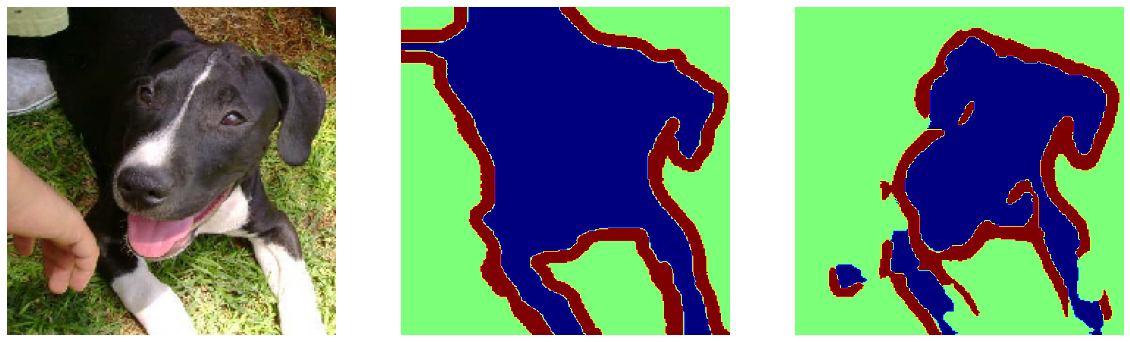

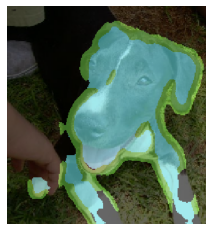

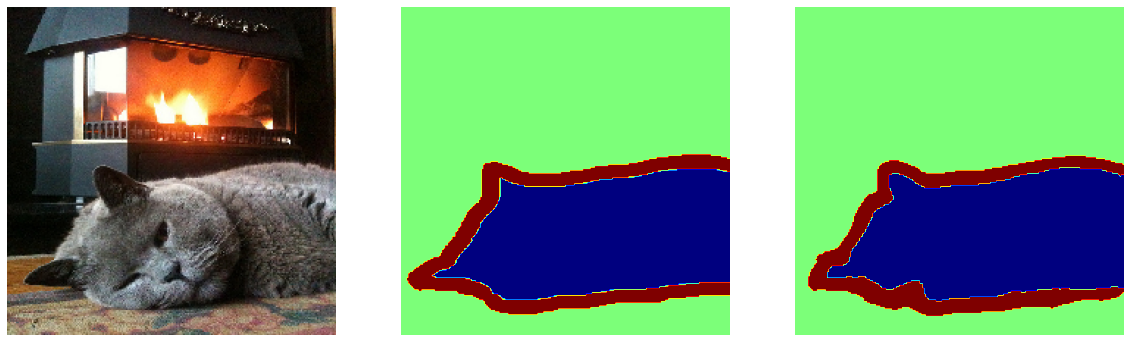

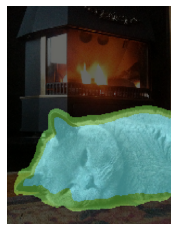

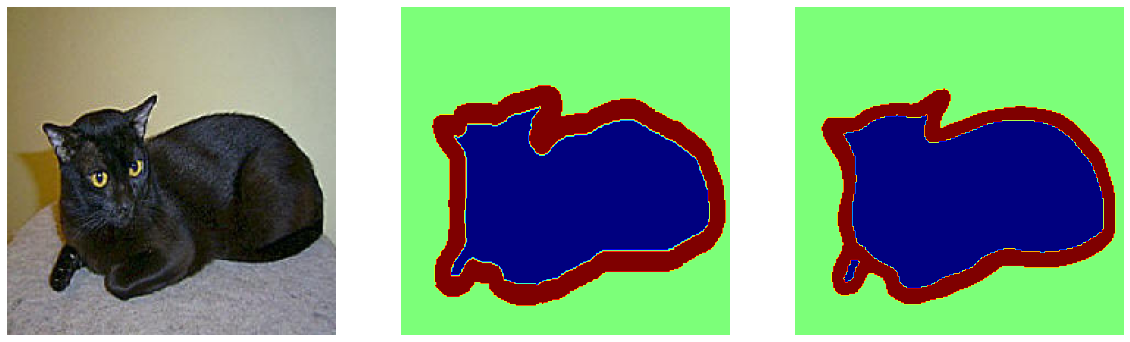

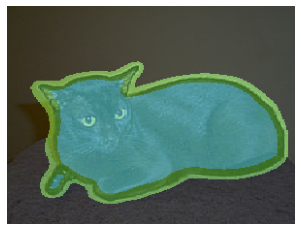

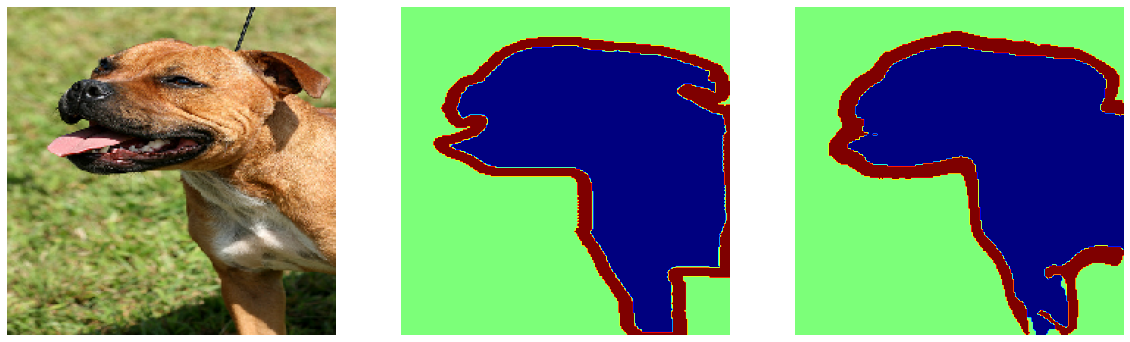

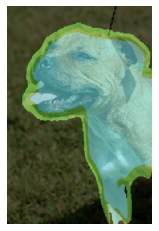

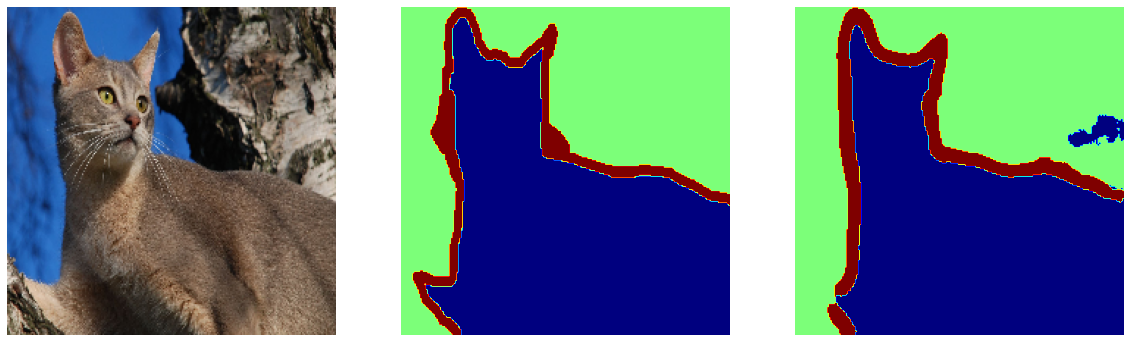

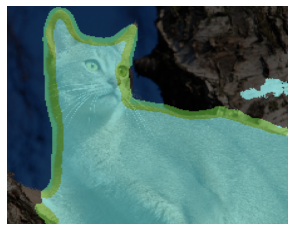

In [58]:
for i in random_idxs:
    x = test_imagePaths[i]
    y = test_maskPaths[i]
    p = preds[i]
    
    filename = os.path.basename(x)

    ## Read image
    x = cv2.imread(x)
    orig_H, orig_W = x.shape[:2]
    x = cv2.resize(x, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

    ## Read mask
    y = read_mask(y)

    # print(x.shape, y.shape, p.shape)

    plt.figure(figsize=(20, 10))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(x)

    plt.subplot(132)
    plt.imshow(y, cmap='jet')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(p, cmap='jet')
    plt.axis('off')
    plt.show()
    
    # given the class ID map obtained from the mask, we can map each of
    # the class IDs to its corresponding color
    colored_p = COLORS[p.astype(np.uint8)]
    # perform a weighted combination of the input image with the colored_p to
    # form an output visualization with different colors for each class
    output = ((0.4 * x) + (0.6 * colored_p)).astype("uint8")
    # resize the output image into original image size
    output = cv2.resize(output, (orig_W, orig_H), interpolation=cv2.INTER_NEAREST)
    plt.imshow(output)
    plt.axis('off')
    plt.show()
    
    if i+1 == 5:
        break